$19^{th}$ Aug 2021

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime



In [2]:
#load the excel sheet containing the variants information

df_meta_seq = pd.read_excel('/home/douso/SarsGenomics/Processed/metadata-seq-MS-Merge@KB8.xlsx', usecols=['S_NUM', 'S', 'DT_CONF', 'G_COV'])

In [3]:
df_meta_seq.head()

,S_NUM,DT_CONF,G_COV,S
0,COVC00854,2020-06-13 00:00:00,94.8,"D614G,"
1,COVC00867,2020-06-13 00:00:00,66.7,"D614G, M900fs, M900fs"
2,COVC00893,2020-06-13 00:00:00,82.6,D614G
3,COVC00915,2020-06-13 00:00:00,NaN,NaN
4,COVC00962,2020-06-14 00:00:00,93.3,D614G


In [117]:
df_meta_seq80 = df_meta_seq.replace(pd.NA, np.nan)[df_meta_seq['G_COV'] >= 80]#.sort_values('DT_CONF')

In [129]:
df_data = df_meta_seq80[df_meta_seq80.index.isin(df_meta_seq80['DT_CONF'].dropna().index)]

In [146]:
df_data_dt = df_data.assign(DT_CONF=df_data['DT_CONF'].apply(lambda x: pd.to_datetime(x, dayfirst=True))).sort_values('DT_CONF')

In [136]:
df_data_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 713 entries, 0 to 1069
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   S_NUM    713 non-null    object        
 1   DT_CONF  713 non-null    datetime64[ns]
 2   G_COV    713 non-null    float64       
 3   S        710 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 27.9+ KB


In [147]:
df_data_dt.tail()

,S_NUM,DT_CONF,G_COV,S
1066,COVC24214,2021-08-23,96.7,"T19R, L452R, T478K, D614G, P681R, D950N,"
1067,COVC24215,2021-08-23,90.1,"L452R, T478K, D614G, P681R, D950N, S974S,"
1069,COVC24217,2021-08-23,93.4,"T19R, L452R, T478K, Q613H, D614G, P681R, D950N..."
936,KEMRI_02_91932,2021-10-02,98.8,"G257S, D614G, P681H"
896,KEMRI_01_89581,2021-12-01,96.5,"H69_V70del, D138H, Y145del, N501Y, A570D, D614..."


	S_NUM	DT_CONF	G_COV	S
1066	COVC24214	2021-08-23	96.7	T19R, L452R, T478K, D614G, P681R, D950N,
1067	COVC24215	2021-08-23	90.1	L452R, T478K, D614G, P681R, D950N, S974S,
1069	COVC24217	2021-08-23	93.4	T19R, L452R, T478K, Q613H, D614G, P681R, D950N...
936	KEMRI_02_91932	2021-10-02	98.8	G257S, D614G, P681H
896	KEMRI_01_89581	2021-12-01	96.5	H69_V70del, D138H, Y145del, N501Y, A570D, D614...

In [148]:
df_fort = df_data_dt.resample(rule='2W', closed='right', on='DT_CONF')

In [267]:
df_spike_trend = pd.DataFrame()
count = 1
observed_mut = []
for i,df in df_fort:
#     print(i, df)
    spike_mut_list = []
    for row in df.itertuples():
        if isinstance(row.S, str):
            mut_list = row.S.rstrip(', ').split(', ')
        else:
            pass#mut_list = []; mut_list.append(pd.NA)
        spike_mut_list.extend(mut_list)
    mut_count = Counter(spike_mut_list)
    df_new = pd.DataFrame(mut_count, index=[i])
    new_col = set(df_new.columns)
    output = sorted(list(new_col)); observed_mut.append(output)
    prev_col = set(df_spike_trend.columns)
    new_m_prev_col = new_col - prev_col
    new_u_prev_col = new_col & prev_col
    prev_m_new_prev_col = prev_col - new_u_prev_col
    if new_m_prev_col == new_col:
        if count == 1:
            output = sorted(list(new_col))#; observed_mut.append(output)
            print(f'Initially detected mutation(s) as of {i.strftime("%Y-%m-%d")} are:\n  {output}\nThe counts:\n  {dict([(k, mut_count[k]) for k in output])}')
        else:
            output = sorted(list(new_col))#; observed_mut.append(output)
            print(f'No new mutation(s) were detected as of {i.strftime("%Y-%m-%d")}')
    elif len(new_m_prev_col) > 0:
        output = sorted(list(new_m_prev_col))#; observed_mut.append(output)
        print(f'The following new mutation(s) identified as of {i.strftime("%Y-%m-%d")}:\n  {output}\nThe counts:\n  {dict([(k, mut_count[k]) for k in output])}')
    elif len(new_m_prev_col) == 0:
        output = sorted(list(prev_col))#; observed_mut.append(output)
        print(f'No new mutation(s) were detected as of {i.strftime("%Y-%m-%d")}')

    count += 1
    df_spike_trend = df_spike_trend.append(df_new)


Initially detected mutation(s) as of 2020-06-14 are:
  ['D614G']
The counts:
  {'D614G': 5}
The following new mutation(s) identified as of 2020-06-28:
  ['G1251V', 'N679K', 'S637S', 'T1116N']
The counts:
  {'G1251V': 1, 'N679K': 1, 'S637S': 1, 'T1116N': 1}
The following new mutation(s) identified as of 2020-07-12:
  ['A263S']
The counts:
  {'A263S': 1}
The following new mutation(s) identified as of 2020-07-26:
  ['F515F', 'L18F', 'N928N', 'R21I', 'S1252F', 'T618T']
The counts:
  {'F515F': 3, 'L18F': 1, 'N928N': 1, 'R21I': 1, 'S1252F': 4, 'T618T': 1}
The following new mutation(s) identified as of 2020-08-09:
  ['A845S']
The counts:
  {'A845S': 1}
The following new mutation(s) identified as of 2020-08-23:
  ['A846S', 'N394I', 'P728P', 'S691S', 'Y28Y']
The counts:
  {'A846S': 1, 'N394I': 1, 'P728P': 4, 'S691S': 1, 'Y28Y': 1}
No new mutation(s) were detected as of 2020-09-06
No new mutation(s) were detected as of 2020-09-20
The following new mutation(s) identified as of 2020-10-04:
  ['D79

### **Regions of interest mutation on spike**
319-541 - RBD
613-705 - S1/S2 junction

In [450]:
window_size = 3
interest_muts = []
for i in range(len(observed_mut) - window_size):
    period_slice = []; period_slice.extend(observed_mut[i:i+window_size])
#     print(len(period_slice))
    counter = Counter()
    for period in period_slice: 
#         print(len(period))
        cnt = Counter(period)
        counter += cnt
#         print(counter)
    for k, v in counter.items(): 
#         print(k,v)
        if v == len(period_slice):
#             if k not in interest_muts:
            interest_muts.append(k)
#             else: pass
        else: pass
print(f'The following mutations consistently appeared across {window_size} periods (are they emerging variants?):\n{dict(Counter(interest_muts))}')
#     print(period_slice)

moc_dict = dict(Counter(interest_muts))
moc_set = set(list(range(319,542)) + list(range(613,706)))
moc_dict_keys = set(moc_dict.keys())

moc_p = re.compile(r'[3-7][0-9]{2,2}')
moc_mut = set(map(lambda x: int(x), moc_p.findall(str(moc_dict_keys))))

moc = moc_set & moc_mut
if len(moc) > 0:
    p = re.compile('|'.join([str(i) for i in moc]))
    moc_fin = {k: v for k,v in moc_dict.items() if p.findall(k)}
    print(f'\n\nThe following consistent mutations occur in either the RBD (319-541) or the S1-S2 (613-705) spike regions:\n {moc_fin}')

The following mutations consistently appeared across 3 periods (are they emerging variants?):
{'D614G': 23, 'G1085E': 2, 'P728P': 3, 'V1228L': 2, 'D571D': 2, 'R683R': 2, 'D80Y': 2, 'I1114I': 1, 'L1200L': 1, 'L54F': 1, 'L841L': 1, 'P681H': 8, 'Q1201K': 1, 'S375S': 2, 'T73I': 1, 'Y145del': 8, 'T716I': 8, 'A570D': 7, 'D1118H': 7, 'H69_V70del': 7, 'E484K': 3, 'N501Y': 6, 'S982A': 6, 'A67V': 2, 'F1062F': 2, 'F888L': 3, 'Q52R': 1, 'Q677H': 2, 'A1190A': 2, 'A845A': 1, 'E583D': 1, 'F157L': 1, 'H146H': 1, 'P681R': 6, 'Q613H': 2, 'V367F': 1, 'D138H': 2, 'G1251V': 2, 'S1252C': 2, 'D950N': 3, 'E156_R158delinsG': 2, 'L452R': 3, 'T19R': 3, 'T478K': 3}


The following consistent mutations occur in either the RBD (319-541) or the S1-S2 (613-705) spike regions:
 {'D614G': 23, 'R683R': 2, 'P681H': 8, 'S375S': 2, 'E484K': 3, 'N501Y': 6, 'Q677H': 2, 'P681R': 6, 'Q613H': 2, 'V367F': 1, 'L452R': 3, 'T478K': 3}


In [266]:
df_spike_trend.sum().sort_values(ascending=False)[:10]

D614G         681.0
Y145del       209.0
H69_V70del    207.0
P681H         203.0
D1118H        194.0
A570D         190.0
S982A         188.0
N501Y         173.0
T716I         165.0
P681R         108.0
dtype: float64

In [390]:
drc_meta = pd.read_excel('/home/douso/Documents/drc_meta.xlsx')

In [391]:
below10 = drc_meta[drc_meta['cubit0'] <= 10]

In [392]:
below10.head()

,sno.,draft,confirmed,well_pos,cubit,Unnamed: 5,sample_ID,cubit0,Ct,coverage
1,2,212,NaN,A2,7.80,NaN,DRC-BKV-212,7.8,0.00,79.059
3,4,146,NaN,A4,5.32,NaN,DRC-BKV-146,5.3,28.45,27.994
4,5,331,NaN,A5,5.50,NaN,DRC-BKV-331,5.5,26.67,96.375
5,6,255,NaN,A6,4.38,NaN,DRC-BKV-255,4.4,28.66,94.288
6,7,128,NaN,A7,3.80,NaN,DRC-BKV-128,3.8,26.47,4.511


<AxesSubplot:xlabel='cubit0', ylabel='coverage'>

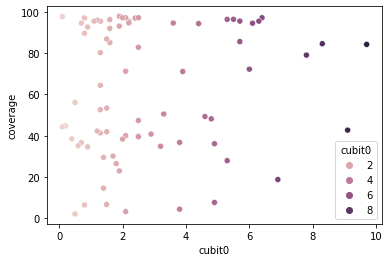

In [403]:
import seaborn as sns
sns.scatterplot(below10['cubit0'], below10['coverage'], hue=below10['cubit0'])

<AxesSubplot:xlabel='cubit0', ylabel='coverage'>

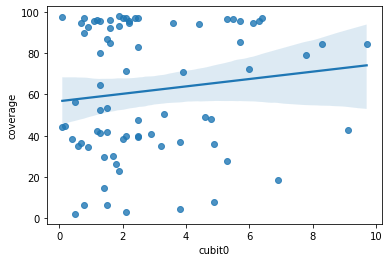

In [405]:
import seaborn as sns
sns.regplot(below10['cubit0'], below10['coverage'])

In [36]:
df_hb = pd.read_excel('/home/douso/Downloads/ILRI NAIROBI1.xlsx', header=2)

In [37]:
df_hb.head()

,SAMPLE ID,DATE SAMPLE COLLECTED,CASE TYPE,PATIENT NAMES,AGE,AGE UNIT,SEX,SAMPLE COLLECTED BY,DATE SAMPLE SENT TO NAIROBI,PCR RESULTS [GENEXPERT],PANBIO RDT RESULTS,SD BIOSENSER RDT RESULTS,VARIANT ILRI RESULTS,CT VALUES,COMMENTS
0,HBCTRH/4198/2021,28th JUL 2021,INITIAL,DERIS MECHASA,46,YEARS,FEMALE,OSUMBA,5TH AUG 2021,NaN,POSITIVE,NaN,21A Delta,NaN,NaN
1,HBCTRH/4285/2021,29th JUL 2021,INITIAL,EDWARD ONANO,68,YEARS,MALE,OSUMBA,5th AUG 2021,NaN,POSITIVE,NaN,21A Delta,NaN,NaN
2,NaN,21st AUG 2021,INITIAL,CHRISTINE AKOTH OTIENO,25,YEARS,FEMALE,OSUMBA,6TH AUG 2021,NaN,POSITIVE,NaN,21A Delta,28.0,NaN
3,HBCTRH/4359/2021,4th AUG 2021,INITIAL,HELLEN NAMBWIRE OBALLE,34,YEARS,FEMALE,OSUMBA,6th AUG 2021,NaN,POSITIVE,NaN,CT VALUE WAS LOW,39.0,NaN
4,HBCTRH/4430/2021,4th AUG 2021,INITIAL,JOHN ODHIAMBO OM0NDI,28,YEARS,MALE,OSUMBA,6th AUG 2021,NaN,POSITIVE,NaN,21A Delta,19.0,NaN


In [38]:
df_hb_res = df_hb[['SAMPLE ID', 'PCR RESULTS [GENEXPERT]', 'PANBIO RDT  RESULTS', 'SD BIOSENSER RDT RESULTS']]

In [39]:
df_pos = pd.read_excel('/home/douso/Documents/TrendData/Results/ResultsMerged/COVID19-results-merged.xlsx')

In [40]:
df_pos[df_pos['COUNT_RES'] == 'Homabay']#.head()

,CASE_ID,S_NUM,NAME,AGE,AGE_UNIT,GEND,OCCU,NAT,COUNT_RES,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF
585,HBCTRH/5142/2021,COVC24292,Ruth Akeyo Otieno,57,Years,F,NaN,Kenya,Homabay,Rachuonyo South,No,NaN,NaN,GW;H;P-J,2021-08-20 00:00:00,2021-08-31 00:00:00,Positive,2021-09-02 00:00:00
586,HBCTRH/5188/2021,COVC24293,Gladys Odero,34,Years,F,NaN,Kenya,Homabay,Rangwe,No,NaN,NaN,GW;H,2021-08-23 00:00:00,2021-08-31 00:00:00,Negative,2021-09-02 00:00:00
587,HBCTRH/5197/2021,COVC24294,Verol Omondi Awuor,34,Years,F,NaN,Kenya,Homabay,Ndhiwa,Yes,Kendu-Bay;Kisii;Kisumu;Homabay;Oyugis,NaN,GW;CO;P-M,2021-08-23 00:00:00,2021-08-31 00:00:00,Negative,2021-09-02 00:00:00
588,HBCTRH/5206/2021,COVC24295,Beatrice Demba Akoth,46,Years,F,NaN,Kenya,Homabay,Homabay,No,NaN,NaN,GW;FC;ST;P-C,2021-08-24 00:00:00,2021-08-31 00:00:00,Negative,2021-09-02 00:00:00
589,HBCTRH/5209/2021,COVC24296,Mathias Odero Otieno,63,Years,M,NaN,Kenya,Homabay,Rachuonyo North,No,NaN,NaN,GW;FC;CO;ST;SB;NV;H;P-M,2021-08-24 00:00:00,2021-08-31 00:00:00,Negative,2021-09-02 00:00:00
590,HBCTRH/5225/2021,COVC24297,Rose Awino,58,Years,F,Business Open,Kenya,Homabay,Rachuonyo North,No,NaN,NaN,GW;FC;CO,2021-08-24 00:00:00,2021-08-31 00:00:00,Positive,2021-09-02 00:00:00
591,HBCTRH/5346/2021,COVC24298,Sarah Muhindi Nyagemi,30,Years,F,NaN,Kenya,Homabay,Homabay,No,NaN,NaN,GW;FC;CO;ST;RN;SB;IC;P-C;P-A,2021-08-25 00:00:00,2021-08-31 00:00:00,Positive,2021-09-02 00:00:00
592,HBCTRH/5353/2021,COVC24299,Byron Castro,13,Years,M,NaN,Kenya,Homabay,Homabay,No,NaN,NaN,NaN,2021-08-26 00:00:00,2021-08-31 00:00:00,Positive,2021-09-02 00:00:00
593,HBCTRH/5354/2021,COVC24300,Rollet Odero,40,Years,F,Business Open,Kenya,Homabay,Rachuonyo North,No,NaN,NaN,NaN,2021-08-26 00:00:00,2021-08-31 00:00:00,Positive,2021-09-02 00:00:00
594,HBCTRH/5355/2021,COVC24301,Joseph Mireri,57,Years,M,NaN,Kenya,Homabay,Suba South,Yes,"Mumias, Oyugis, Homabay",NaN,GW;FC;H;P-C,2021-08-26 00:00:00,2021-08-31 00:00:00,Positive,2021-09-02 00:00:00


In [47]:
df_pos[df_pos['COUNT_RES'] == 'Kisumu']

,CASE_ID,S_NUM,NAME,AGE,AGE_UNIT,GEND,OCCU,NAT,COUNT_RES,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF
7997,KAM/MAL4319,COVC514,Elly Atieno Onyango,30,NaN,M,Driver,NaN,Kisumu,Kisumu West,Y,Malindi,Nil,Asymtomatic,6th June 2020,"June 9, 2020",negative,2020-06-09 00:00:00
8029,KAM/MAL4311,COVC546,Collins Odwour Nyalowa,35,NaN,M,Nil,NaN,Kisumu,Nil,Y,Mombasa,Nil,Asymtomatic,6th June 2020,"June 9, 2020",negative,2020-06-09 00:00:00


In [53]:
mask1 = df_pos['CASE_ID'].str.contains('HBCT') == True
mask2 = df_pos['CASE_ID'].str.contains('COV190') == True

In [57]:
df_pos_res = df_pos[mask1 | mask2 == True][['CASE_ID', 'RESULT', 'S_NUM']]#.head()

In [58]:
df_pos_res.head()

,CASE_ID,RESULT,S_NUM
570,HBCTRH/4198/2021,Positive,COVC24024
571,HBCTRH/4285/2021,Positive,COVC24025
585,HBCTRH/5142/2021,Positive,COVC24292
586,HBCTRH/5188/2021,Negative,COVC24293
587,HBCTRH/5197/2021,Negative,COVC24294


In [50]:
df_sya_res = df_pos[df_pos['CASE_ID'].str.contains('COV190') == True][['CASE_ID', 'RESULT', 'S_NUM']]#.head()

In [51]:
df_sya_res.head()

,CASE_ID,RESULT,S_NUM
17214,COV1900721,Positive,COVC24171
17215,COV1901021,Positive,COVC24172
17216,COV1901521,Positive,COVC24173
17217,COV1901921,Positive,COVC24174
17218,COV1902021,Positive,COVC24175


In [59]:
df_res_mrg = df_hb_res.merge(df_pos_res, how='outer', right_on='CASE_ID', left_on='SAMPLE ID')

In [60]:
df_ct = pd.read_excel('/home/douso/Documents/RunSheets/Cts/runsheet-cts.xlsx')

In [61]:
df_res_ct_mrg=df_res_mrg.merge(df_ct, how='left', right_on='Sample_Name', left_on='S_NUM')

In [62]:
df_res_ct_mrg.to_excel('/home/douso/Documents/TrendData/Results/ResultsMerged/COVID19-results-HB_merged.xlsx', index=False)